# clustering of reviews of fine foods bought on amazon #

**importing and cleaning the dataset**

In [222]:
import pandas as pd
import modules3 as mod
from sklearn.decomposition import TruncatedSVD as SVD
import matplotlib.pyplot as plt
from wordcloud import WordCloud as WC
from PIL import Image
from sklearn.cluster import KMeans

In [223]:
df1=pd.read_csv("/Users/eugeniobaldo/Downloads/archive-2/Reviews.csv", nrows=100000,header="infer")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
Id                        100000 non-null int64
ProductId                 100000 non-null object
UserId                    100000 non-null object
ProfileName               99996 non-null object
HelpfulnessNumerator      100000 non-null int64
HelpfulnessDenominator    100000 non-null int64
Score                     100000 non-null int64
Time                      100000 non-null int64
Summary                   99998 non-null object
Text                      100000 non-null object
dtypes: int64(5), object(5)
memory usage: 7.6+ MB


In [224]:
df1.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               4
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [225]:
df1["ProfileName"].fillna("",inplace=True)
df1["Summary"].fillna('',inplace=True)
df1.set_index("Id", inplace=True)
df1['Datetime']=df1.Time.apply(lambda value: pd.to_datetime(value, unit='s'))

**in this section it will be used NLTK in order to process the review plain text, and then it will be added a column with the tokens to the dataset**

In [226]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [227]:
stop_words=set(stopwords.words('english'))

In [228]:
wordlist_1=df1["Text"].apply(lambda text: mod.new_text(text,stop_words)).to_list()

In [230]:
df1["taken_words"]=wordlist_1

In [231]:
df1.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime,taken_words
Id,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,"[bought, several, vitality, canned, dog, food,..."
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,"[product, arrived, labeled, jumbo, salted, pea..."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,"[confection, around, century, light, pillowy, ..."
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,"[looking, secret, ingredient, robitussin, beli..."
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,"[great, taffy, great, price, wide, assortment,..."


**the idea of our group is to cluster the reviews text by taking into account only the adjectives. This choice is related to the role played by adjectives in the sentence. the use of a particular combinations of adjectives rather than other one gives a specific connotation to the text. It has been decided to use as dimensions only the first 1000 most popular adjectives in the reviews. This allows to consider general adjectives and not adjectives that are too specific.** 

In [232]:
adj_list=df1["taken_words"].apply(lambda wordlist_1: mod.take_adj(wordlist_1))
df1["adjectives"]=adj_list
list_agg=adj_list.to_list()

In [233]:
flat_list_adj= [item for sublist in adj_list for item in sublist]

In [234]:
adjectives_list=pd.Series(flat_list_adj).value_counts()

In [235]:
all_adjectives=list(adjectives_list[0:1000].index)

len(all_adjectives)

1000

**here it is created a dictionary where reviews are the keys and vectors of size 1000 are the values. In order to represent a particular review text has been decided to use a binary representation for each adjective considered. If the adjective is in the review text, it will be assigned 1, otherwise it will be assigned 0.**

In [236]:
dict_adj=mod.df_words_dict(list_agg,all_adjectives)

**here it is created a dataset where each row is a review as in the starting one, whereas the columns are the adjectives.**

In [237]:
df_adjectives=pd.DataFrame.from_dict(data=dict_adj, orient='index',columns=all_adjectives)

In [238]:
df_adjectives.columns

Index(['good', 'great', 'little', 'much', 'many', 'delicious', 'sweet', 'nice',
       'hot', 'favorite',
       ...
       'moroccan', 'tooth', 'couscous', 'shortbread', 'guilt', 'watery',
       'smoky', 'meat', 'fda', 'elderly'],
      dtype='object', length=1000)

**SVD method to reduce the dimensionality** 

**the SVD method is used to reduce the number of features which will be used for clustering and in general for machine learning models. This method allows to save computation time but at the same time to save a good amount of information provided by the features. It has been set a target value for the variance retained of 60%. So it will be choosen a number of components which is capable of retaining 60% of all the variance.**

In [239]:
svd_agg= SVD(n_components=120, n_iter=7, random_state=42)

df_adj=svd_agg.fit_transform(df_adjectives, y=None)

print(svd_agg.explained_variance_ratio_.sum())

0.6011645734746375


**having the number of components to be used, they will be taken the top features ordered in descending order by variance. These features will approximately correspond to the most popular adjectives.**

In [241]:
columns_variance=mod.variance_columns(df_adjectives,120)

In [242]:
df_adjectives=df_adjectives[columns_variance]

df_adjectives

,good,great,little,much,delicious,many,nice,favorite,sweet,small,...,bean,vegetable,brown,noodle,tiny,super,particular,live,flavor,nut
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


**elbow method for number of cluster selection**

**the number of clusters can be utmost the total number of rows. Given certain  boundaries, the more are the cluster the more specific will be the clustering. However an high number of clusters can raise computational problems. To choose an acceptable number of clusters, it will be used the elbow method which computes the inertia for a specific cluster number. From the following plot, it is possible to observe the inertia curve for clusters numbers in range(2,30). the first derivative of this curve appears less negative after a cluster number of 14. So, it will be used 14 as cluster number.**

In [243]:
from tqdm import tqdm
elbow = {}
for k in tqdm(range(2, 30)):
    model = KMeans(k)
    model.fit(df_adjectives)
    model.predict(df_adjectives)    
    elbow[k] = model.inertia_

100%|██████████| 28/28 [13:42<00:00, 29.39s/it]


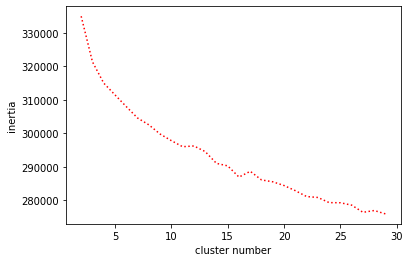

In [244]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('cluster number')
plt.ylabel('inertia')
plt.plot(list(elbow.keys()), list(elbow.values()), color='red', linestyle='dotted')
plt.show()

**nested list to be used for our own clustering implementation**

In [245]:
word_vector1=[]

for idx in range(len(df_adjectives)):
    
    list_w1=list(df_adjectives.iloc[idx])
    
    word_vector1.append(list_w1)
    


**in the following section will be executed two k-means algorithm. The first is our own algorithm with random initialization, the second is the one provided from sk-learn with k++ initialization.**

**our k-means implementation**

In [247]:
my_clusters=mod.cluster_labels(word_vector1,30,14)

cluster labels for iteration 0 for the first 100 items are [6, 9, 9, 6, 9, 9, 9, 6, 9, 6, 9, 9, 9, 6, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 12, 9, 6, 9, 6, 6, 6, 9, 9, 9, 6, 9, 6, 6, 9, 6, 6, 9, 6, 6, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 6, 9, 9, 9, 9, 5, 9, 6, 9, 6, 6, 6, 6, 9, 9, 6, 6, 9, 6, 9, 9, 2, 9, 9, 12, 9, 9, 9, 6, 9, 9, 2, 9, 9, 9, 9, 9, 9, 9]
cluster labels for iteration 1 for the first 100 items are [6, 9, 10, 6, 9, 9, 9, 6, 10, 6, 10, 10, 9, 6, 10, 10, 6, 10, 10, 10, 9, 10, 10, 10, 9, 10, 10, 9, 12, 10, 6, 9, 6, 6, 6, 3, 10, 9, 6, 9, 6, 1, 9, 6, 6, 1, 6, 6, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 6, 10, 3, 9, 10, 5, 10, 6, 10, 6, 1, 6, 6, 10, 10, 6, 6, 9, 6, 9, 9, 2, 9, 9, 12, 10, 10, 9, 6, 9, 9, 2, 9, 10, 9, 9, 10, 9, 10]
cluster labels for iteration 2 for the first 100 items are [6, 0, 10, 6, 12, 9, 4, 6, 10, 6, 10, 10, 9, 6, 10, 10, 6, 10, 10, 10, 2, 10, 10, 10, 10, 10, 10, 12, 12, 10, 6, 12, 6, 6, 6, 3, 10, 9, 6, 10, 0, 1, 3, 6, 6, 1, 6, 6, 10, 10, 6, 9, 10, 9, 3,

cluster labels for iteration 21 for the first 100 items are [6, 0, 10, 6, 12, 8, 12, 6, 10, 0, 10, 10, 10, 6, 10, 10, 6, 10, 10, 10, 2, 10, 10, 10, 10, 10, 10, 12, 3, 10, 1, 12, 6, 6, 6, 12, 10, 9, 6, 10, 0, 11, 12, 6, 6, 7, 6, 6, 10, 4, 6, 10, 10, 7, 12, 7, 13, 12, 12, 8, 6, 6, 10, 12, 10, 10, 5, 10, 6, 10, 1, 1, 6, 1, 10, 10, 6, 6, 12, 6, 9, 3, 11, 10, 10, 12, 10, 2, 10, 6, 10, 12, 2, 9, 10, 10, 7, 10, 5, 10]
cluster labels for iteration 22 for the first 100 items are [6, 0, 10, 6, 12, 8, 12, 6, 10, 0, 10, 10, 10, 6, 10, 10, 6, 10, 10, 10, 2, 10, 10, 10, 10, 10, 10, 12, 3, 10, 1, 12, 6, 6, 6, 12, 10, 9, 6, 10, 0, 11, 12, 6, 6, 7, 6, 6, 10, 4, 6, 10, 10, 7, 12, 7, 13, 12, 12, 8, 6, 6, 10, 12, 10, 10, 5, 10, 6, 10, 1, 1, 6, 1, 10, 10, 6, 6, 12, 6, 9, 3, 11, 10, 10, 12, 10, 2, 10, 6, 10, 12, 2, 9, 10, 10, 7, 10, 5, 10]
cluster labels for iteration 23 for the first 100 items are [6, 0, 10, 6, 12, 8, 12, 6, 10, 0, 10, 10, 10, 6, 10, 10, 6, 10, 10, 10, 2, 10, 10, 10, 10, 10, 10, 12, 3, 10,

**sklearn with k++ initialization results**

In [248]:
kmeans = KMeans(n_clusters=14,init='k-means++', max_iter=30, verbose=False).fit(df_adjectives)

clusters=kmeans.labels_

print(clusters[0:100])

[ 6  0  0  6  2  9  2  6  0  7  0  0  0  3  0  0  6  0  0  0  0  0  0  0
  0  0  0  2  2  0 12  2  8  8  6 10  0 11  6  0  8  1  7  6  6  4  6  6
  0  7  6  0 13  4  2  4  5  2  2  0  6  9  0  2  0  0 11  0  6  0 12 12
  8 12  0  0  6 13  2 10 11  2 12 10  0  2  0  0 13  8  0  2  8 11  0  0
 13  0  0  0]


**cluster values for both algorithms are added to the starting dataset**

In [249]:
df1["own_cluster"]=my_clusters
df1["sklearn_cluster_k++"]=clusters
df1.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime,taken_words,adjectives,own_cluster,sklearn_cluster_k++
Id,,,,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,"[bought, several, vitality, canned, dog, food,...","[several, dog, good, finicky]",6,6
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,"[product, arrived, labeled, jumbo, salted, pea...","[labeled, peanut, small, unsalted, sure, repre...",0,0
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,"[confection, around, century, light, pillowy, ...","[nut, filbert, tiny, powdered, tiny, mouthful,...",10,0
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,"[looking, secret, ingredient, robitussin, beli...","[secret, good]",6,6
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,"[great, taffy, great, price, wide, assortment,...","[great, taffy, great, wide, quick]",12,2


**comments about results differences between our clustering implementation and sklearn implementation using histograms**

In [250]:


clusters=pd.Series(clusters).value_counts().sort_values().to_dict()

my_clusters=pd.Series(my_clusters).value_counts().sort_values().to_dict()



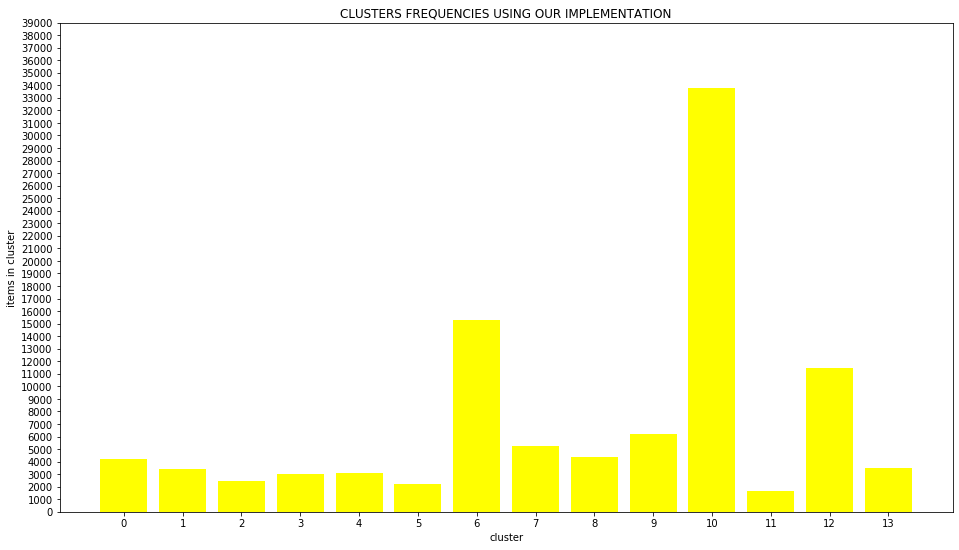

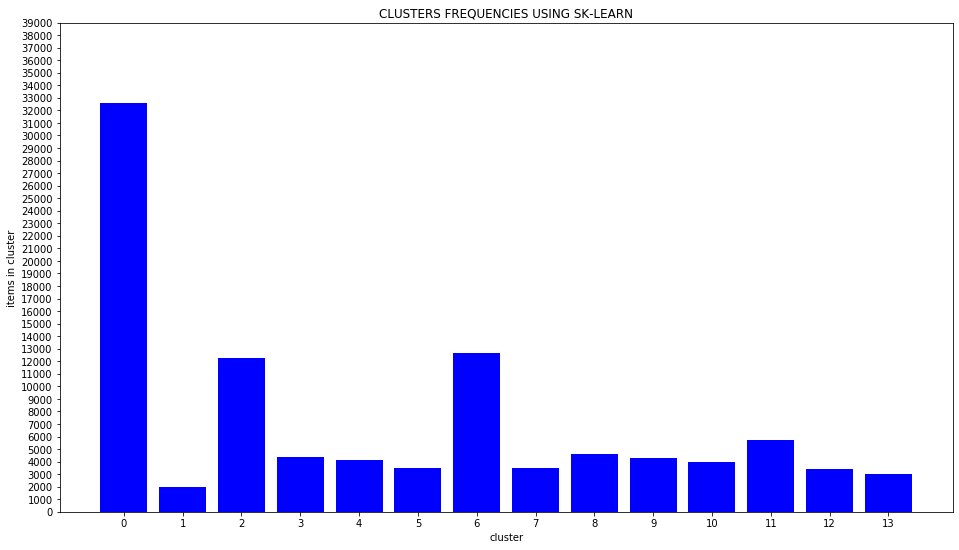

In [271]:
import numpy as np

plt.figure(figsize=(16,9))

plt.title("clusters frequencies using our implementation".upper())

plt.bar(my_clusters.keys(),my_clusters.values(),color='yellow')

plt.xticks(np.arange(0,14,1))

plt.yticks(np.arange(0,40000,1000))

plt.xlabel("cluster")

plt.ylabel('items in cluster')

plt.show()



plt.figure(figsize=(16,9))

plt.title('clusters frequencies using sk-learn'.upper())

plt.bar(clusters.keys(),clusters.values(), color='blue')

plt.xticks(np.arange(0,14,1))

plt.yticks(np.arange(0,40000,1000))

plt.xlabel("cluster")

plt.ylabel('items in cluster')

plt.show()

**In the previous histograms it is possible to observe the number of reviews for each cluster. The cluster labels of our implementation and sk-learn will not correspond each other, given that the initialization of centers changes each time that the script is executed. It can be observed that for both implementations there exists a major cluster that has the higher number of reviews. Then there are two middle clusters which have approximately the same number in our implementation and slightly difference in sk-learn and finally there are minor clusters. The number of items for the two implementations for each cluster results not equal but looks similar. In addition to graphs, it is possible to see, from the sequences of labels patterns, many common sequences between the two results.**  

## cluster analysis ##

**provide the number of products for each cluster**

In [252]:
df_count=df1.groupby(["own_cluster"]).count()

df_count=df_count.ProductId

df_count

own_cluster
0      4215
1      3398
2      2494
3      2998
4      3102
5      2220
6     15304
7      5285
8      4382
9      6207
10    33803
11     1670
12    11442
13     3480
Name: ProductId, dtype: int64

**pie chart describing the percentages of products per cluster**

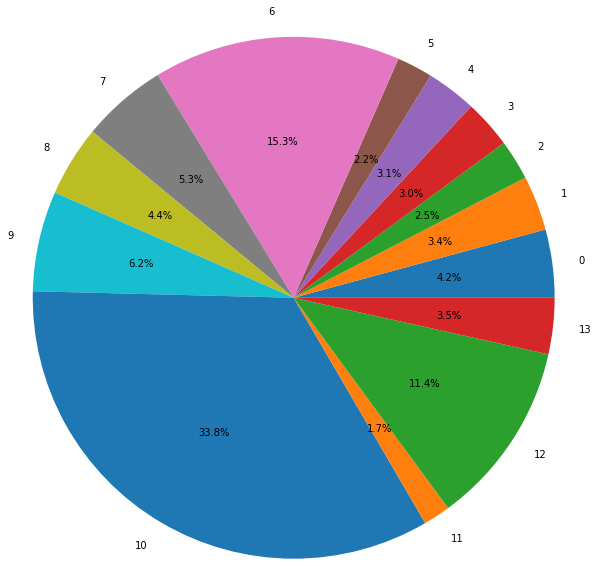

In [253]:

plt.pie(df_count,labels=df_count.index,radius=3,autopct='%1.1f%%')

plt.show()

**score distribution for each cluster**

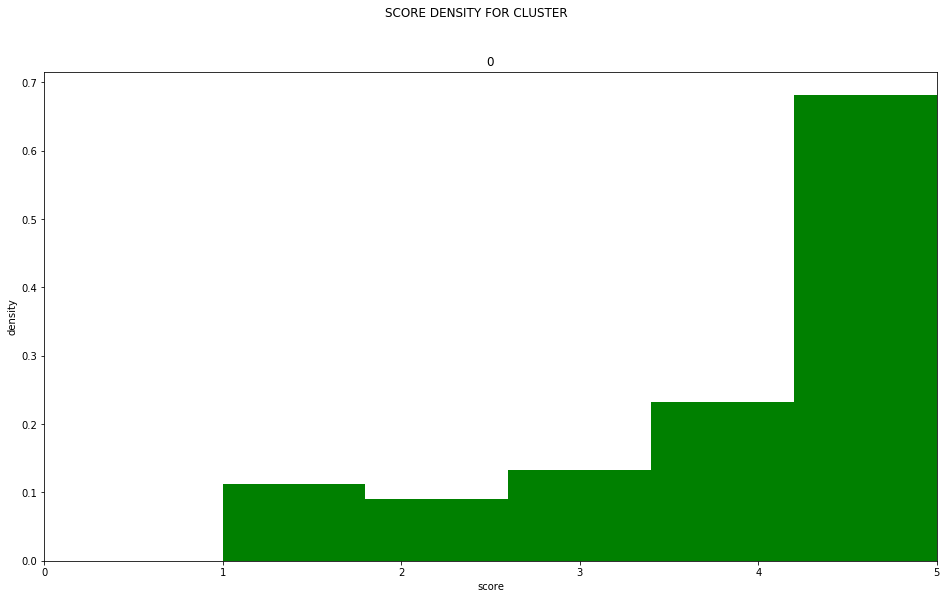

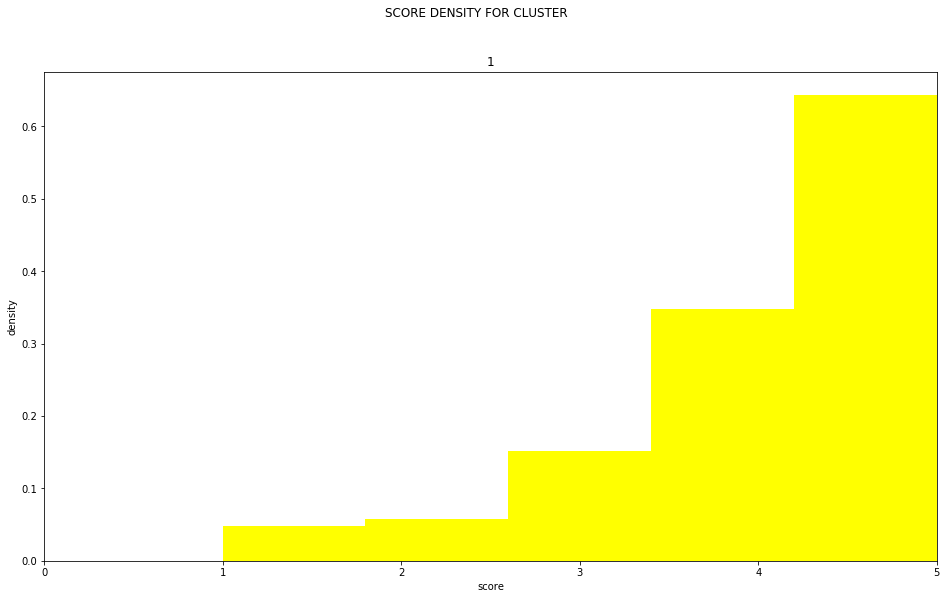

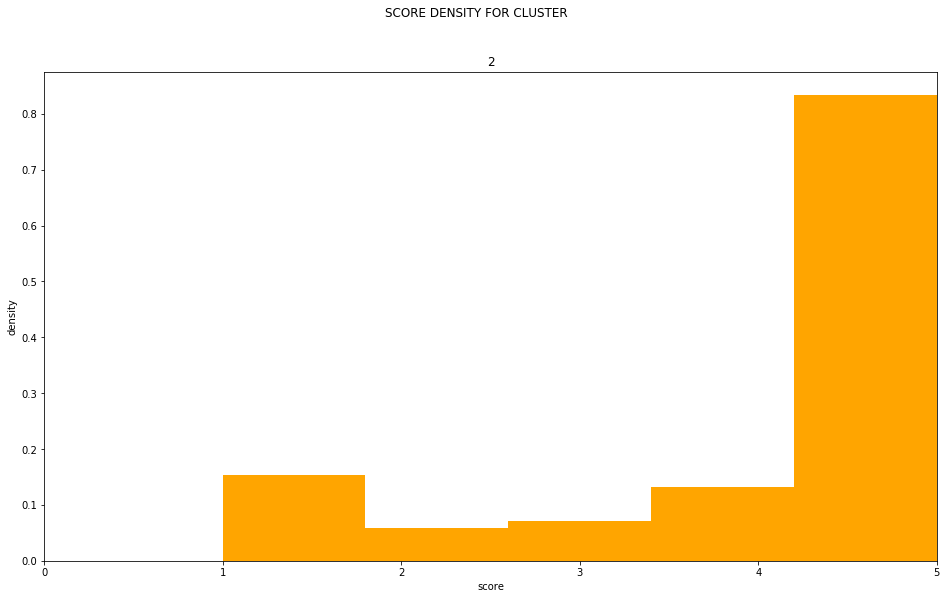

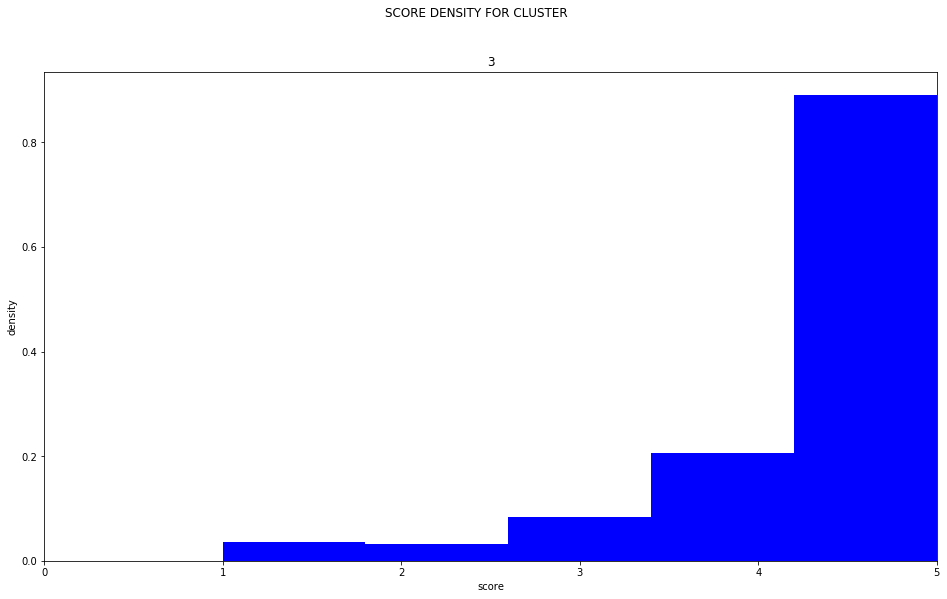

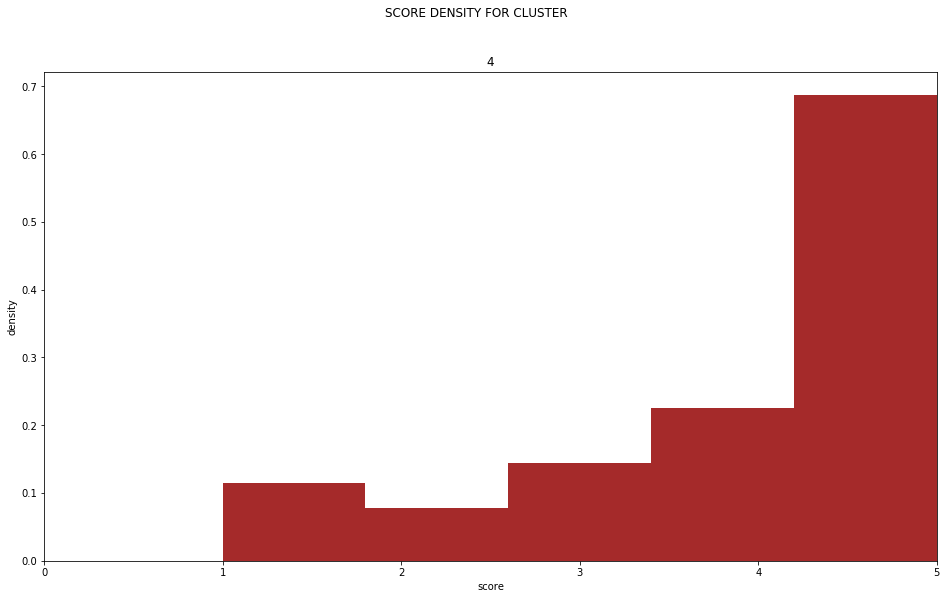

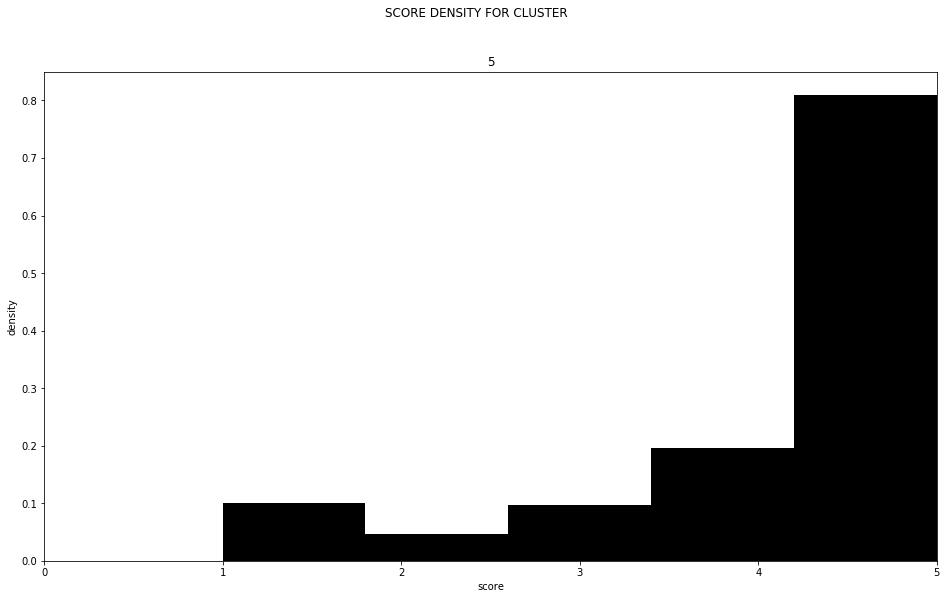

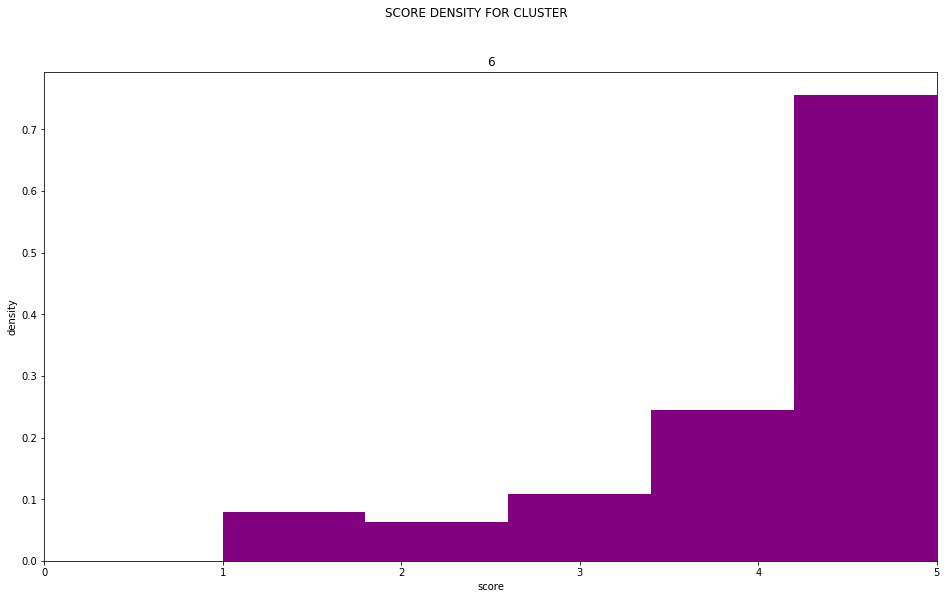

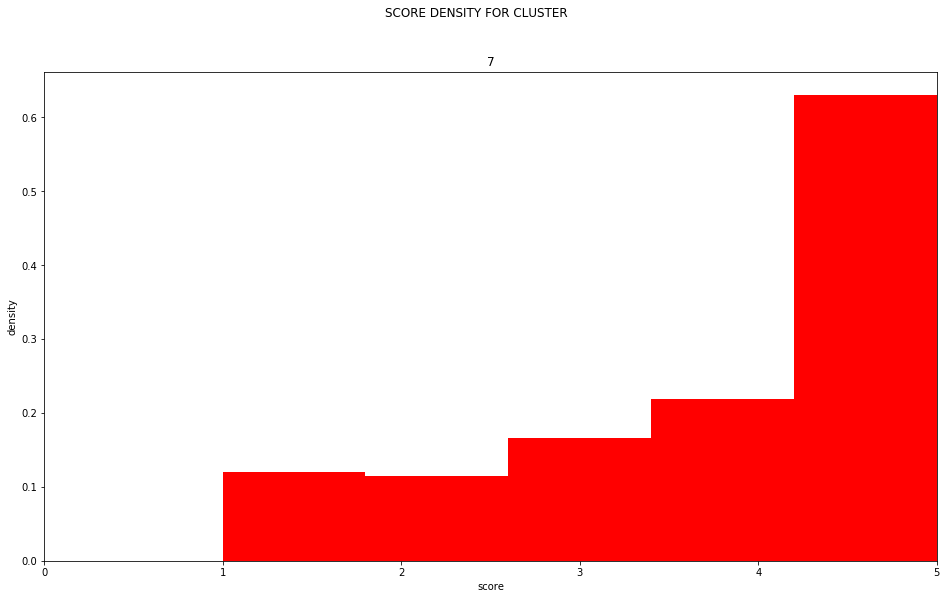

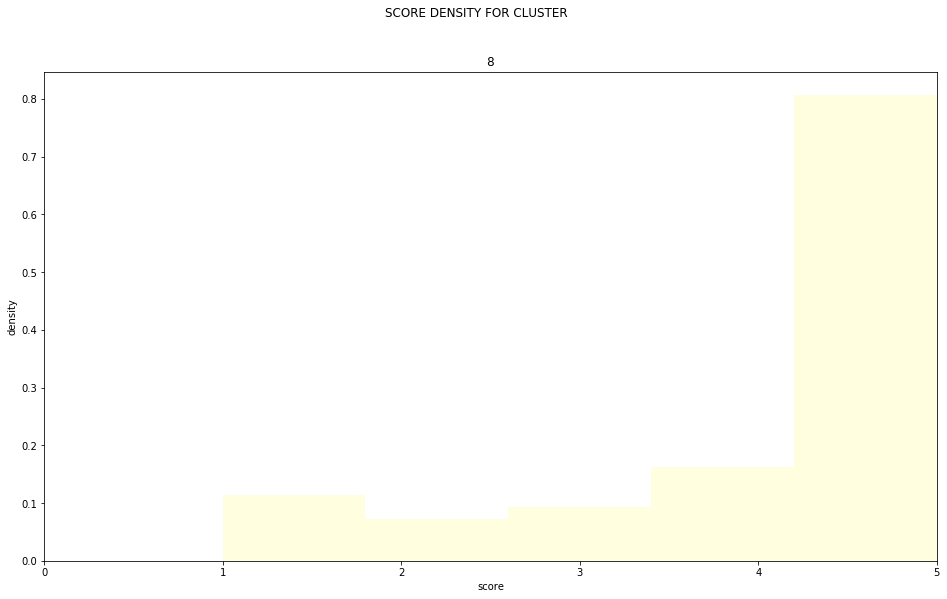

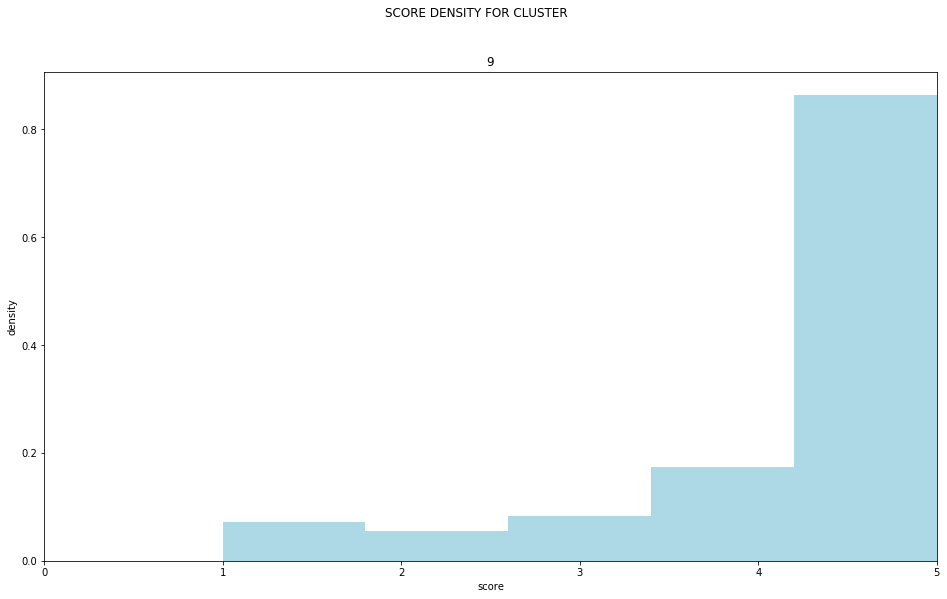

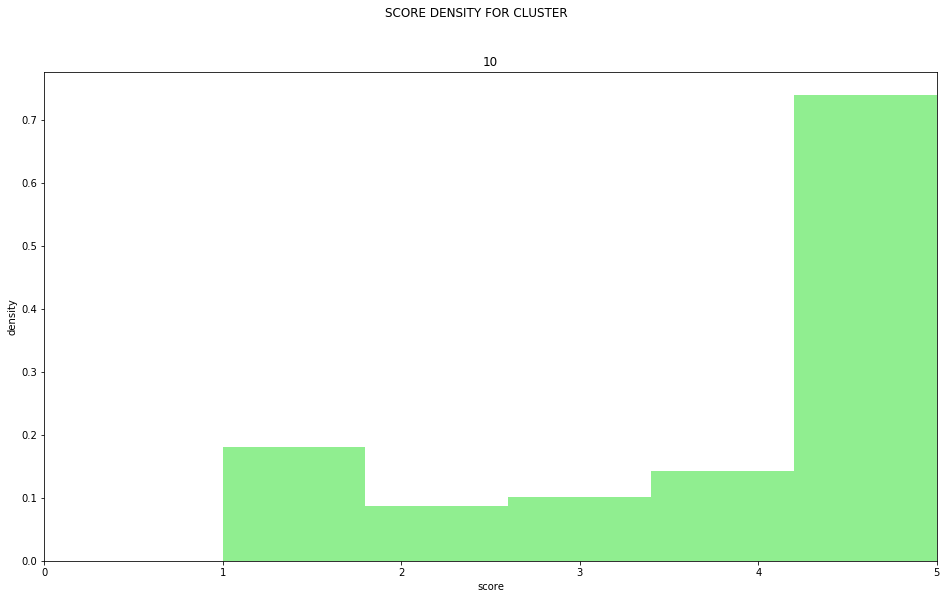

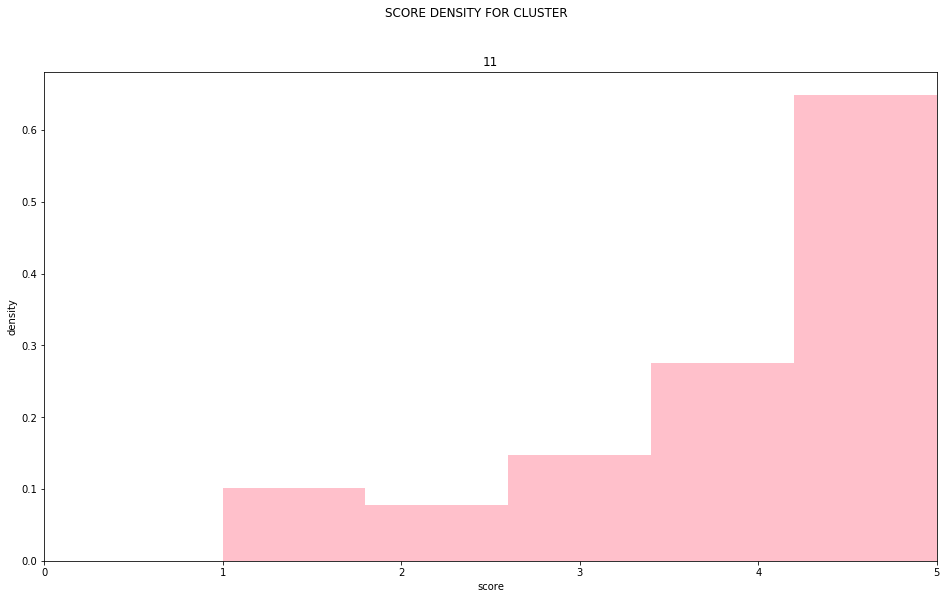

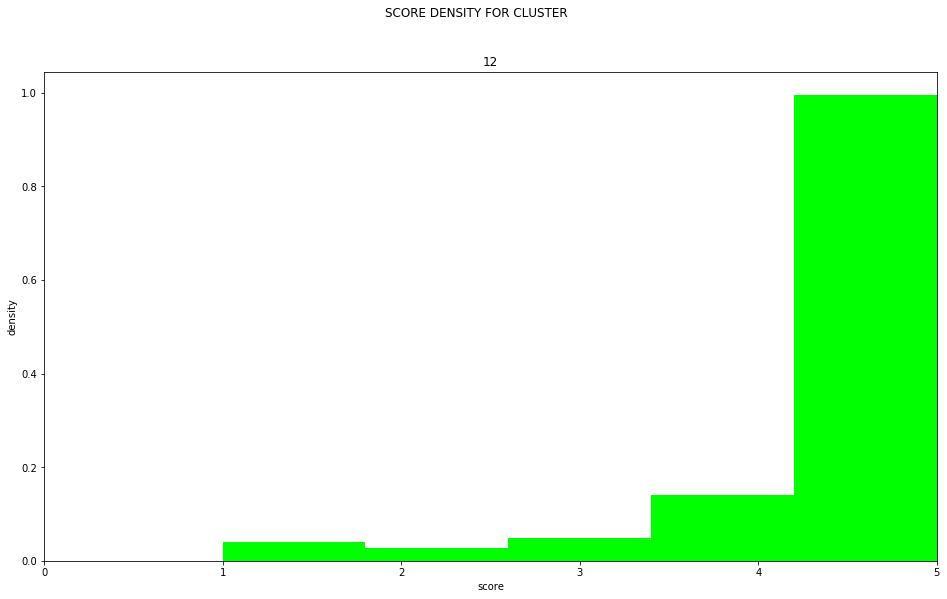

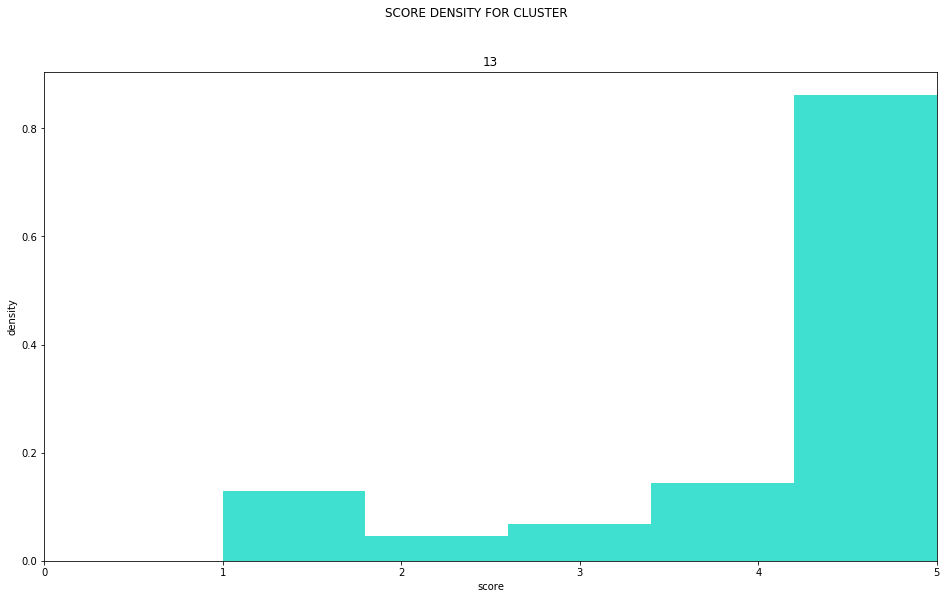

In [254]:
score=mod.score_distribution(df1,14)

In [255]:
means=list(score.values())

means

[4.026097271648873,
 4.18481459682166,
 4.148356054530874,
 4.507338225483656,
 4.035138620245003,
 4.254504504504505,
 4.227914270778881,
 3.8987701040681175,
 4.180282975810132,
 4.36329950056388,
 3.9391769961246044,
 4.0341317365269465,
 4.620083901415836,
 4.248850574712644]

In [256]:
std=np.std(means)

std

0.1981140160241222

**Given the mean values for each cluster and the standard deviation of the means, it is reasonable to claim that the mean difference among clusters is not statistically significant**

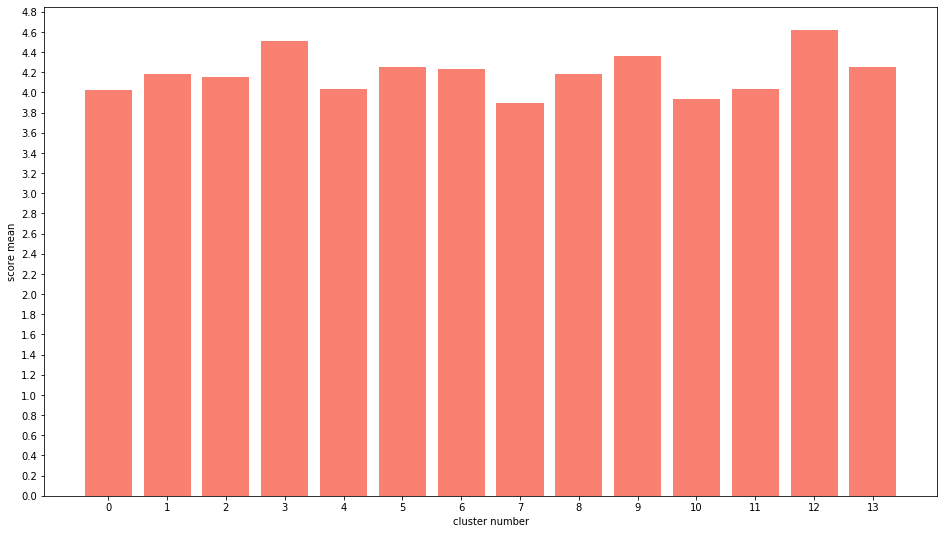

In [257]:
plt.figure(figsize=(16,9))

plt.bar(list(score.keys()),means,color='salmon')

plt.xlabel("cluster number")

plt.xticks(np.arange(0,14,1))

plt.yticks(np.arange(0,5,0.2))

plt.ylabel('score mean')

plt.show()

**Get the number of unique users writing reviews in each cluster**

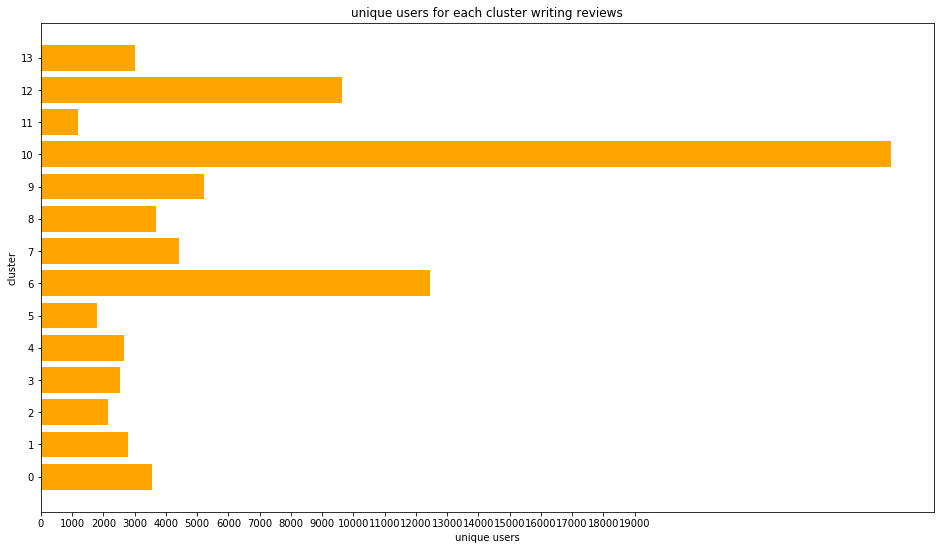

In [258]:
uniques=mod.unique_users(df1, 14)

plt.figure(figsize=(16,9))
plt.title('unique users for each cluster writing reviews')
plt.barh(uniques.index, uniques, color='orange')
plt.yticks(np.arange(0,14,1))
plt.xticks(np.arange(0,20000,1000))
plt.xlabel('unique users')
plt.ylabel('cluster')
plt.show()

**WordCloud**

**In this section will be displayed 3 different wordclouds. Our group has not suceeded to find a particular library which provide food items. So, with the first 2 wordclouds we have tried 2 different approaches: the first was to take all the nouns into account with nltk tagging, as done before with the adjectives. However with this approach are considered nouns that are not food at all, in addition to wrong nltk tags. With the second word cloud we have created manually a list with a subset of foods, which, looking empirically to the reviews, should be among the most bought. This approach looses a lot of information, but gives categories which belong to food and beverages.**

**in the third word cloud, our group has visualized the most popular adjectives in each cluster. when this wordcloud is compared with the previous cloud, it is possible to see a few associations among the most popular products in each cluster and the most popular adjectives in the same cluster.**


In [259]:
from wordcloud import WordCloud as WC

In [260]:
coffee_image=np.array(Image.open('/Users/eugeniobaldo/Downloads/caffè.jpg'))

In [261]:
df1.Text

Id
1         I have bought several of the Vitality canned d...
2         Product arrived labeled as Jumbo Salted Peanut...
3         This is a confection that has been around a fe...
4         If you are looking for the secret ingredient i...
5         Great taffy at a great price.  There was a wid...
                                ...                        
99996     I just love it and will buy another box when I...
99997     My late father in law used to have a rating sy...
99998     This is my favorite brand of Korean ramen. It ...
99999     I do like these noodles although, to say they ...
100000    I love this noodle and have it once or twice a...
Name: Text, Length: 100000, dtype: object

In [262]:
food_list=['tea','coffee','chocolate','water','cocoa','sauce','juice','ice cream','cake','butter','bread','milk','pizza','pasta','eggs','cookies','meat','soup','ramen','noodles','beans','popcorn','corn','broccoli','tuna','salmon','bacon','coke','onion','nuggets','potatoes','salt','pepper','sugar','almonds','nuts','peanuts','flour','rice','wine','beer','chicken','pork']

In [263]:
names_list=df1["taken_words"].apply(lambda wordlist_1: mod.take_names(wordlist_1))

In [265]:
flat_list_nn= [item for sublist in names_list for item in sublist]

nouns_list=pd.Series(flat_list_nn).value_counts().index



In [266]:
nouns_list

Index(['taste', 'product', 'flavor', 'food', 'coffee', 'tea', 'dog', 'time',
       'price', 'bag',
       ...
       'gamer', 'curly', 'fertility', 'sucs', 'fellix', 'eventho', 'purpleone',
       'experiece', 'positioning', 'sixteen'],
      dtype='object', length=26040)

**First word cloud**

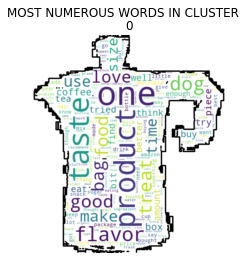

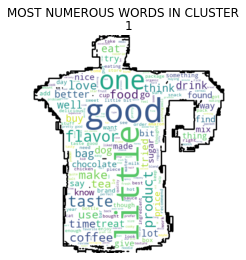

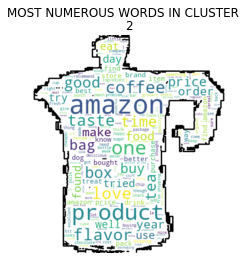

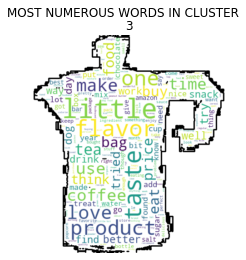

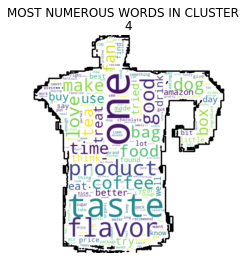

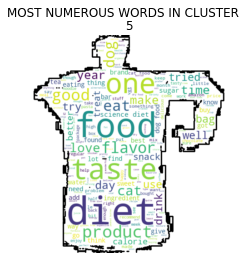

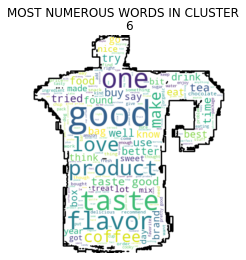

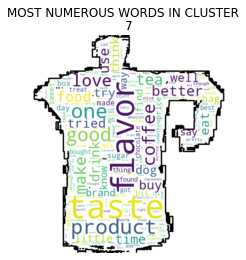

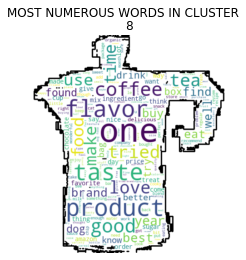

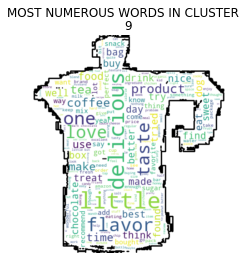

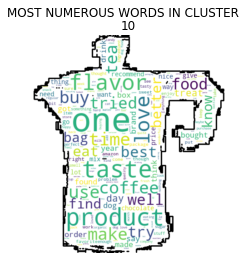

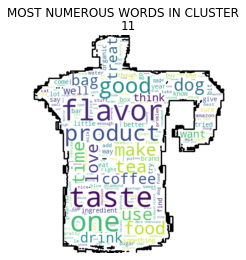

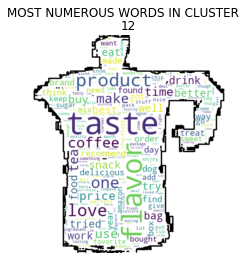

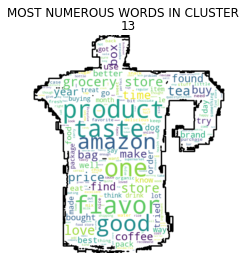

In [267]:
mod.word_cloud(coffee_image,df1,14,nouns_list)

**second word cloud**

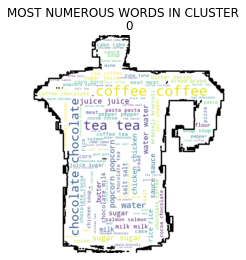

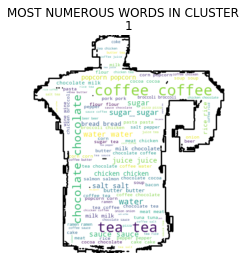

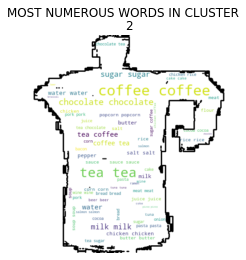

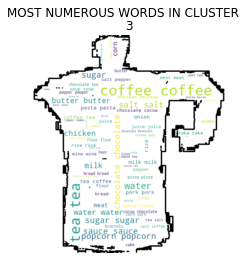

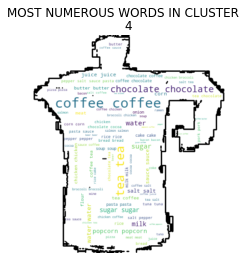

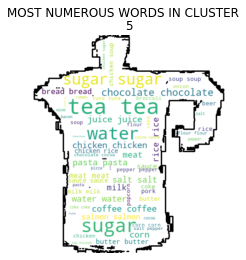

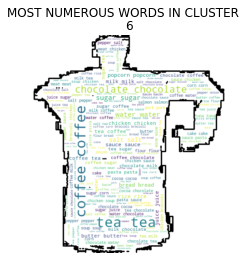

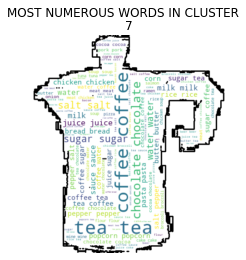

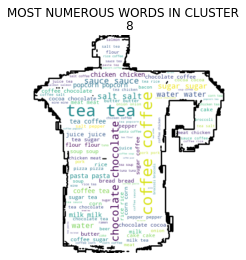

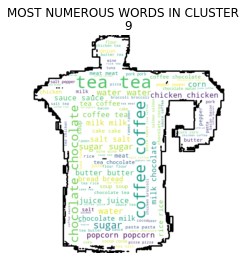

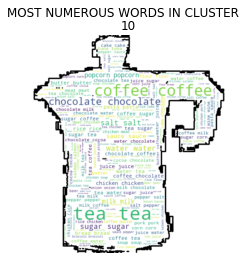

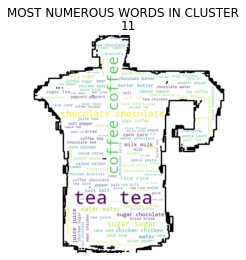

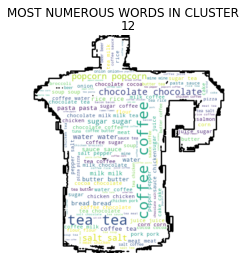

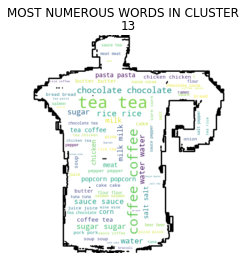

In [268]:
mod.word_cloud(coffee_image,df1,14,food_list)

**third word cloud**

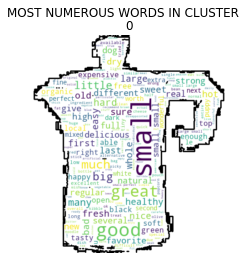

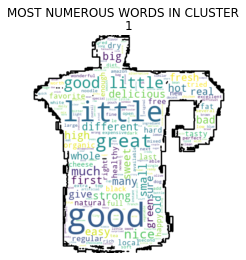

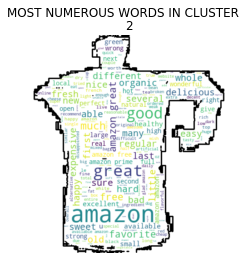

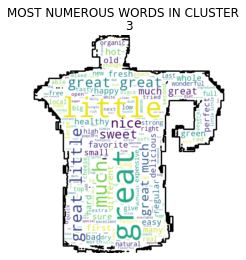

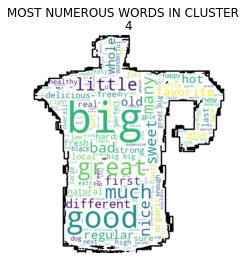

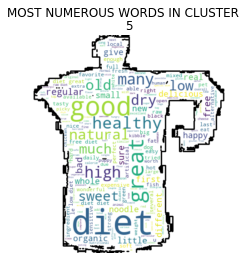

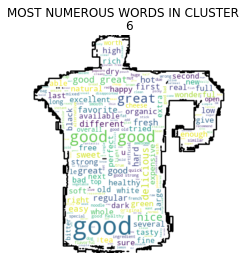

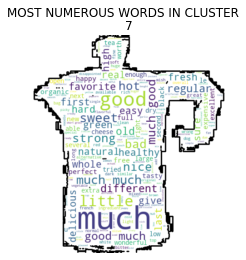

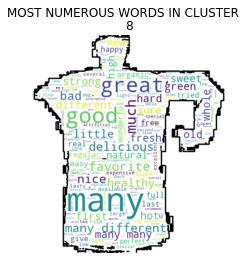

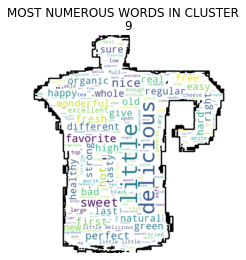

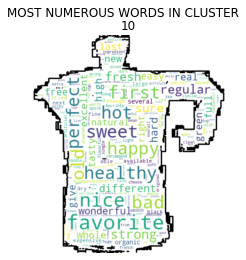

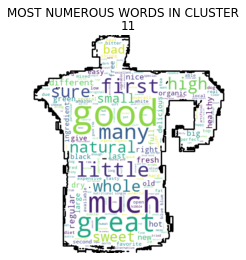

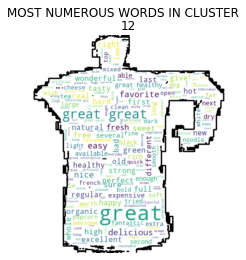

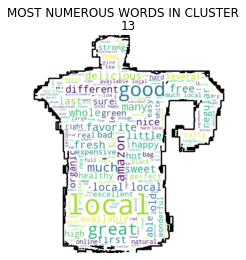

In [270]:
mod.word_cloud_1(coffee_image,df1,14,all_adjectives)